# How Fast Can You CitiBike?

## ML Question 4: Data Cleaning

<a id=toc></a>
## Table of Contents

<ul>
    <li><a href=#01-import-packages>Import Packages</a>
    <li><a href=#02-load-dataset>Load Dataset and Check Properties</a>
    <li><a href=#03-normalize>Normalize Data and Remove Outliers</a>
        <ul>
            <li><a href=#03-a-durations>For Ride Duration</a>
            <li><a href=#03-b-speeds>For Ride Speeds</a>
        </ul>
    <li><a href=#04-final>Final Results</a>
        <ul>
            <li><a href=#04-a-durations>Ride Duration</a>
            <li><a href=#04-b-distances>Ride Distances</a>
            <li><a href=#04-c-speeds>Ride Speeds</a>
        </ul>
    <li><a href=#05-records>Records</a>
        <ul>
            <li><a href=#05-a-duration>Longest Ride (Duration)</a>
            <li><a href=#05-b-distance>Longest Ride (Distance)</a>
            <li><a href=#05-c-speed>Fastest Ride</a>
        </ul>
    <li><a href=#06-save>Save Cleaned File</a>
</ul>

<a id=01-import-packages></a>
## Import Packages

Import all necessary packages.

In [2]:
# Apache parquet files (to save space)
import pyarrow as pa
import pyarrow.parquet as pq

# Dataframes and numerical
import pandas as pd
import numpy as np
import statistics

# Increase pandas default display 
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

# Suppress scientific notation of data in pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

# For data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Library for model creation
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split,GridSearchCV

# Model evaluation
from sklearn.metrics import mean_squared_error,r2_score

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

<a href=#toc>Back to the top</a>

<a id=02-load-dataset></a>
## Load Dataset and Check Properties

Load **.parquet** file of all CitiBike rides from May 2021 through April 2022 into **pandas** dataframe.

In [3]:
CB_Data = pq.read_table('data/202105-202204-citibike-tripdata.parquet').to_pandas()

Preview the dataset.

In [3]:
CB_Data.head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
1,Member,Classic Bike,2021-05-13 12:48:08,Broadway & W 25 St,40.74,-73.99,Manhattan,Flatiron District,2021-05-13 13:07:37,E 2 St & Avenue B,40.72,-73.98,Manhattan,East Village,2021,5,19,3,12,19.48,1.81,5.57
2,Member,Classic Bike,2021-05-16 08:30:13,46 Ave & 5 St,40.75,-73.95,Queens,Long Island City,2021-05-16 08:45:47,34th Ave & Vernon Blvd,40.77,-73.94,Queens,Long Island City,2021,5,19,6,8,15.57,2.26,8.69
3,Member,Classic Bike,2021-05-01 08:38:14,46 Ave & 5 St,40.75,-73.95,Queens,Long Island City,2021-05-01 08:54:27,34th Ave & Vernon Blvd,40.77,-73.94,Queens,Long Island City,2021,5,17,5,8,16.22,2.26,8.35
4,Member,Classic Bike,2021-05-09 08:12:31,46 Ave & 5 St,40.75,-73.95,Queens,Long Island City,2021-05-09 08:27:05,34th Ave & Vernon Blvd,40.77,-73.94,Queens,Long Island City,2021,5,18,6,8,14.57,2.26,9.29
5,Member,Classic Bike,2021-05-27 07:52:27,E 123 St & Lexington Ave,40.80,-73.94,Manhattan,East Harlem,2021-05-27 08:09:01,1 Ave & E 78 St,40.77,-73.95,Manhattan,Upper East Side,2021,5,21,3,7,16.57,3.25,11.78


In [4]:
CB_Data.tail()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
28816543,Member,Classic Bike,2022-04-22 13:08:15,Allen St & Rivington St,40.72,-73.99,Manhattan,Lower East Side,2022-04-22 13:29:31,W 29 St & 9 Ave,40.75,-74.00,Manhattan,Chelsea,2022,4,16,4,13,21.27,2.64,7.45
28816544,Member,Classic Bike,2022-04-13 17:10:49,St. Nicholas Terrace & Convent Ave,40.82,-73.95,Manhattan,Harlem,2022-04-13 17:26:08,E 138 St & Grand Concourse,40.81,-73.93,Bronx,Mott Haven,2022,4,15,2,17,15.32,1.75,6.85
28816545,Member,Classic Bike,2022-04-12 15:58:47,E 88 St & 1 Ave,40.78,-73.95,Manhattan,Upper East Side,2022-04-12 16:41:17,E 91 St & 2 Ave,40.78,-73.95,Manhattan,Upper East Side,2022,4,15,1,15,42.50,0.25,0.36
28816546,Member,Electric Bike,2022-04-28 15:52:49,W 55 St & 6 Ave,40.76,-73.98,Manhattan,Midtown,2022-04-28 16:06:31,E 91 St & 2 Ave,40.78,-73.95,Manhattan,Upper East Side,2022,4,17,3,15,13.70,3.23,14.13
28816547,Member,Electric Bike,2022-04-11 19:55:31,W 87 St & West End Ave,40.79,-73.98,Manhattan,Upper West Side,2022-04-11 20:09:19,E 91 St & 2 Ave,40.78,-73.95,Manhattan,Upper East Side,2022,4,15,0,19,13.80,2.51,10.92


Description of the dataset.

In [5]:
CB_Data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
member_casual,27143436,2,Member,20092339,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rideable_type,27143436,2,Classic Bike,19461880,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,27143436,15052189,2021-08-20 17:29:55,40,2021-05-01 00:00:01,2022-04-30 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_name,27143436,1588,W 21 St & 6 Ave,128058,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_lat,27143436.00,NaN,NaN,NaN,NaT,NaT,40.74,0.04,40.63,40.72,40.74,40.76,40.88
start_lng,27143436.00,NaN,NaN,NaN,NaT,NaT,-73.98,0.02,-74.04,-73.99,-73.98,-73.96,-73.88
start_boro,27143436,5,Manhattan,19674401,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_hood,27143436,89,Chelsea,2073923,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ended_at,27143436,15064923,2021-05-05 23:31:09,60,2021-05-01 00:02:01,2022-05-01 21:40:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_name,27143436,1668,W 21 St & 6 Ave,129117,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a href=#toc>Back to the top</a>

<a id=03-normalize></a>
## Normalize Data and Remove Outliers

<a id=03-a-durations></a>
### For Ride Durations

While the EDA illustrated the distribution of rides in terms of time and location, there appears to be irregularities in the data with respect to calculated values such as ride duration, and speed. How is a negative ride duration possible? This needs to be explored in a univariate analysis of **duration_min**, which will directly affect **speed_mph**.

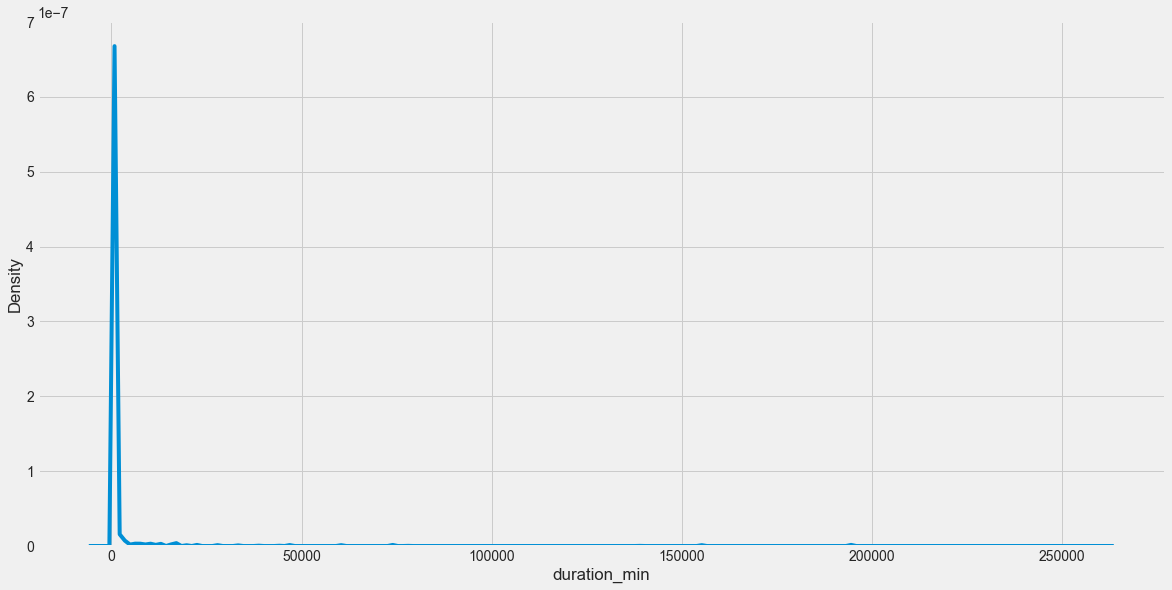

In [6]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.duration_min)
plt.show()

The negative ride durations are adversely affecting the plotting of the density of this data. Investigate where such durations are.

In [7]:
CB_neg_ride = CB_Data.loc[CB_Data.duration_min <= 0]

In [8]:
CB_neg_ride.shape

(4374, 22)

In [9]:
CB_neg_ride.head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
1458,Member,Classic Bike,2021-05-24 20:12:57,Centre St & Chambers St,40.71,-74.00,Manhattan,Civic Center,2021-05-24 20:12:35,Warren St & W Broadway,40.71,-74.01,Manhattan,Tribeca,2021,5,21,0,20,-0.37,0.45,-73.46
4638,Member,Classic Bike,2021-05-27 19:56:48,Allen St & Stanton St,40.72,-73.99,Manhattan,Lower East Side,2021-05-27 19:56:25,Stanton St & Norfolk St,40.72,-73.99,Manhattan,Lower East Side,2021,5,21,3,19,-0.38,0.29,-44.76
5523,Casual,Classic Bike,2021-05-21 20:48:46,Broad St & Bridge St,40.70,-74.01,Manhattan,Financial District,2021-05-21 20:48:07,Maiden Ln & Pearl St,40.71,-74.01,Manhattan,Financial District,2021,5,20,4,20,-0.65,0.54,-49.50
6299,Member,Classic Bike,2021-05-23 10:04:03,8 Ave & W 33 St,40.75,-73.99,Manhattan,Chelsea,2021-05-23 10:03:38,Lexington Ave & E 36 St,40.75,-73.98,Manhattan,Murray Hill,2021,5,20,6,10,-0.42,1.32,-189.88
7042,Casual,Classic Bike,2021-05-28 11:57:10,Huron St & Franklin St,40.73,-73.96,Brooklyn,Greenpoint,2021-05-28 11:57:09,Banker St & Meserole Ave,40.73,-73.96,Brooklyn,Greenpoint,2021,5,21,4,11,-0.02,0.60,-2148.31


More than 4,000 of these rides have unexplained errors in their data collection and need to be discarded.

In [10]:
CB_Data = CB_Data[~(CB_Data.duration_min <= 0)]

In [11]:
CB_Data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
member_casual,27139062,2,Member,20088636,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rideable_type,27139062,2,Classic Bike,19457695,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,27139062,15050603,2021-08-20 17:29:55,40,2021-05-01 00:00:01,2022-04-30 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_name,27139062,1588,W 21 St & 6 Ave,128050,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_lat,27139062.00,NaN,NaN,NaN,NaT,NaT,40.74,0.04,40.63,40.72,40.74,40.76,40.88
start_lng,27139062.00,NaN,NaN,NaN,NaT,NaT,-73.98,0.02,-74.04,-73.99,-73.98,-73.96,-73.88
start_boro,27139062,5,Manhattan,19670692,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_hood,27139062,89,Chelsea,2073596,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ended_at,27139062,15063410,2021-05-05 23:31:09,60,2021-05-01 00:02:01,2022-05-01 21:40:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_name,27139062,1668,W 21 St & 6 Ave,129110,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This improves the data a little by removing the infinity values at the maximum and minimum for **speed_mph**. Now, to examine the rest of the outlying data causing an absurdly high mean **duration_min**.

First, use the maximum distance ever traveled as a rule of thumb to assess how long a ride duration should be at its maximum.

In [12]:
CB_Data.sort_values(by=['distance_mi'], ascending = False).head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
18201184,Casual,Classic Bike,2021-10-05 11:44:58,45 St & 4 Ave,40.65,-74.01,Brooklyn,Sunset Park,2021-10-05 21:55:45,W 225 St & Exterior St,40.87,-73.91,Bronx,Kingsbridge,2021,10,40,1,11,610.78,22.56,2.22
21231254,Member,Electric Bike,2021-12-06 16:44:44,W 212 St & 10 Ave,40.87,-73.92,Manhattan,Inwood,2021-12-06 18:25:39,57 St & 4 Ave,40.64,-74.02,Brooklyn,Sunset Park,2021,12,49,0,16,100.92,22.43,13.34
18764165,Member,Electric Bike,2021-11-10 17:16:39,Bailey Ave & W 193 St,40.87,-73.91,Bronx,Kingsbridge,2021-11-10 19:11:13,45 St & 4 Ave,40.65,-74.01,Brooklyn,Sunset Park,2021,11,45,2,17,114.57,22.37,11.72
2915557,Casual,Electric Bike,2021-06-17 18:33:57,55 St & 7 Ave,40.64,-74.01,Brooklyn,Sunset Park,2021-06-17 20:21:27,Southern Blvd & E 175 St,40.84,-73.89,Bronx,East Morrisania,2021,6,24,3,18,107.50,22.23,12.41
14576500,Casual,Electric Bike,2021-09-08 17:10:48,Paul Ave & Mosholu Pkwy,40.88,-73.89,Bronx,Kingsbridge,2021-09-08 18:46:38,6 Ave & 9 St,40.67,-73.98,Brooklyn,Park Slope,2021,9,36,2,17,95.83,21.38,13.39


A 22.56-mile ride from Sunset Park in Brooklyn to Kingsbridge in the Bronx is long, but should not take more than ten hours to complete. Therefore, examine what the average travel times for such rides are in order to develop an idea as to how long such an extreme distance shuld take on average.

In [13]:
CB_sp_kb = CB_Data.loc[(CB_Data.start_hood == 'Sunset Park') & (CB_Data.end_hood == 'Kingsbridge')]

In [14]:
CB_sp_kb.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
member_casual,2,1,Casual,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rideable_type,2,2,Electric Bike,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,2,2,2021-07-17 19:08:59,1,2021-07-17 19:08:59,2021-10-05 11:44:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_name,2,2,34 St & 4 Ave,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_lat,2.00,NaN,NaN,NaN,NaT,NaT,40.65,0.00,40.65,40.65,40.65,40.65,40.66
start_lng,2.00,NaN,NaN,NaN,NaT,NaT,-74.01,0.00,-74.01,-74.01,-74.01,-74.00,-74.00
start_boro,2,1,Brooklyn,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_hood,2,1,Sunset Park,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ended_at,2,2,2021-07-17 21:21:02,1,2021-07-17 21:21:02,2021-10-05 21:55:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_name,2,2,W Fordham Rd & Loring Pl N,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


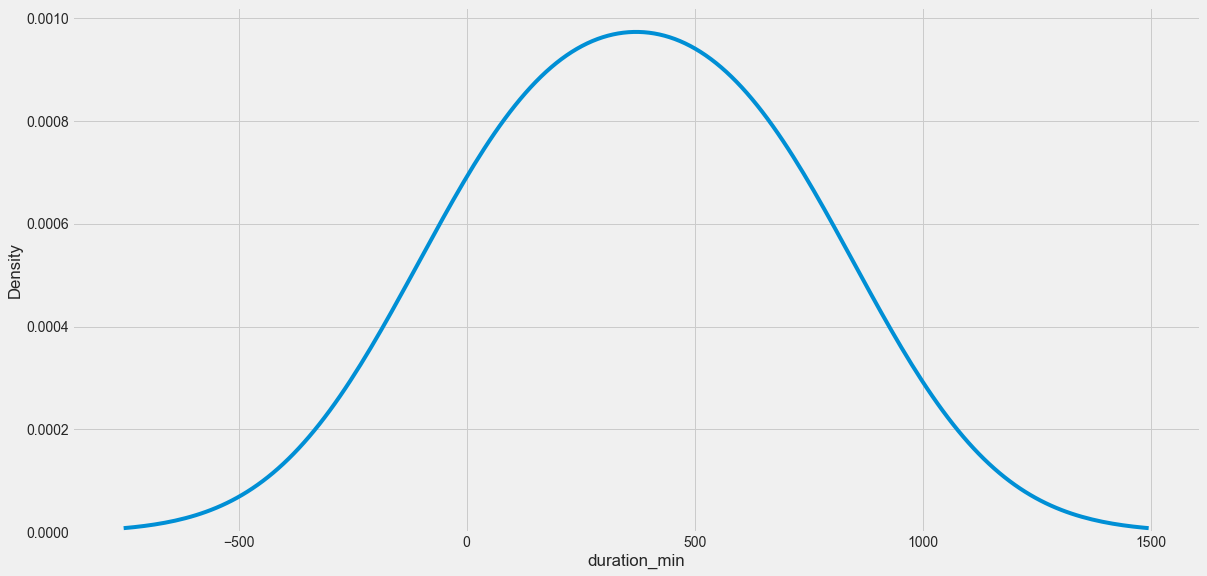

In [15]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_sp_kb.duration_min)
plt.show()

<function matplotlib.pyplot.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)>

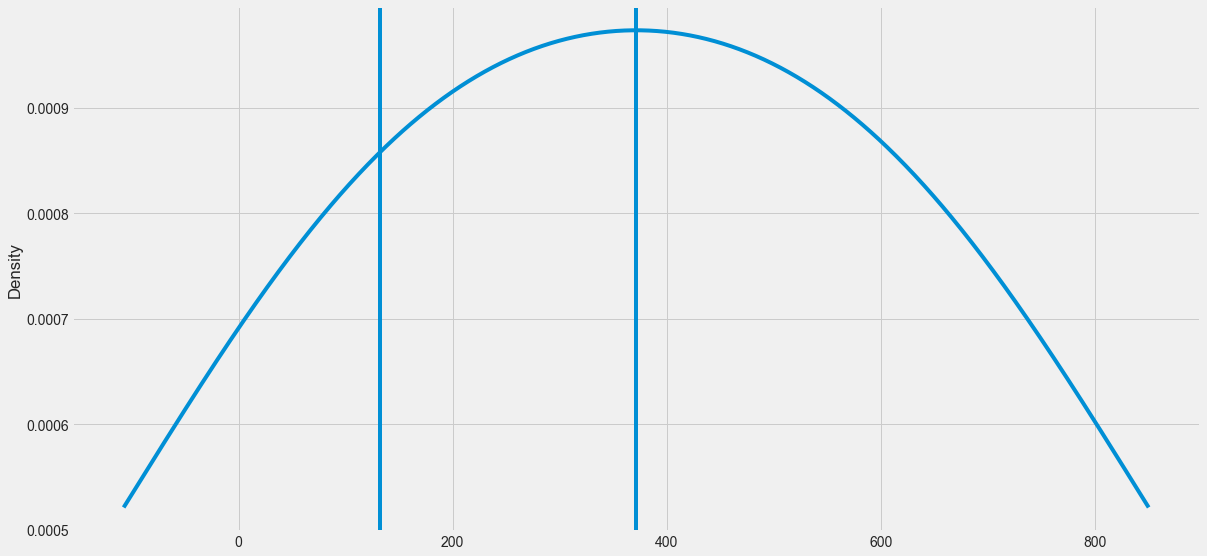

In [16]:
# Visualizing mean, median, and mode for ride duration.
plt.figure(figsize = (18,9))
CB_sp_kb.duration_min.plot(kind='density')
plt.axvline(CB_sp_kb.duration_min.mean(), label='Mean')
plt.axvline(CB_sp_kb.duration_min.median(), label='Median')
plt.axvline(statistics.mode(CB_sp_kb.duration_min), label='Mode')
plt.boxplot

In [22]:
print(f'The average ride duration to travel from Sunset Park to Kingsbridge is: {CB_sp_kb.duration_min.mean()} min.')
print(f'This brings the average ride speed to: {CB_sp_kb.distance_mi.max()/(CB_sp_kb.duration_min.mean()/60)} mph.')
print(f'The median ride duration to travel from Sunset Park to Kingsbridge is: {CB_sp_kb.duration_min.median()} min.')
print(f'This brings the median ride speed to: {CB_sp_kb.distance_mi.max()/(CB_sp_kb.duration_min.mean()/60)} mph.')
print(f'The most common ride duration to travel from Sunset Park to Kingsbridge is: {statistics.mode(CB_sp_kb.duration_min)} min.')
print(f'This brings the typical ride speed to: {CB_sp_kb.distance_mi.max()/(statistics.mode(CB_sp_kb.duration_min)/60)} mph.')

The average ride duration to travel from Sunset Park to Kingsbridge is: 371.41666666666663 min.
This brings the average ride speed to: 3.6444765219750255 mph.
The median ride duration to travel from Sunset Park to Kingsbridge is: 371.41666666666663 min.
This brings the median ride speed to: 3.6444765219750255 mph.
The most common ride duration to travel from Sunset Park to Kingsbridge is: 132.05 min.
This brings the typical ride speed to: 10.250808947647789 mph.


Therefore, these seems to be a lot of junk ride data suggesting that it would take more than six hours on average to ride 22.56 miles at speed of 3.64 mph, which is basically walking speed. A travel time of slightly more than two hours seems more reasonable. Therefore, an maximum ride cap of 2.5 hours (150 min) should be assumed in order to provide some bubble of safety for this extreme case.

In [23]:
CB_Data.loc[CB_Data.duration_min <= 150].describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
member_casual,27073028,2,Member,20069367,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rideable_type,27073028,2,Classic Bike,19412320,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,27073028,15030160,2021-08-20 17:29:55,40,2021-05-01 00:00:01,2022-04-30 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_name,27073028,1588,W 21 St & 6 Ave,127886,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_lat,27073028.00,NaN,NaN,NaN,NaT,NaT,40.74,0.04,40.63,40.72,40.74,40.76,40.88
start_lng,27073028.00,NaN,NaN,NaN,NaT,NaT,-73.98,0.02,-74.04,-73.99,-73.98,-73.96,-73.88
start_boro,27073028,5,Manhattan,19625980,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_hood,27073028,89,Chelsea,2069575,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ended_at,27073028,15041555,2021-05-05 23:31:09,60,2021-05-01 00:02:01,2022-05-01 01:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_name,27073028,1663,W 21 St & 6 Ave,128965,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This provides a further improvement over the dataset by normalizing the **duration_min** and **distance_mi** by a great amount. Now, it is the absurdly high maximum **speed_mph** that needs to be investigated.

<a href=#toc>Back to the top</a>

<a id=03-b-speeds></a>
### For Ride Speeds

In [25]:
CB_Data = CB_Data.loc[CB_Data.duration_min <= 150]

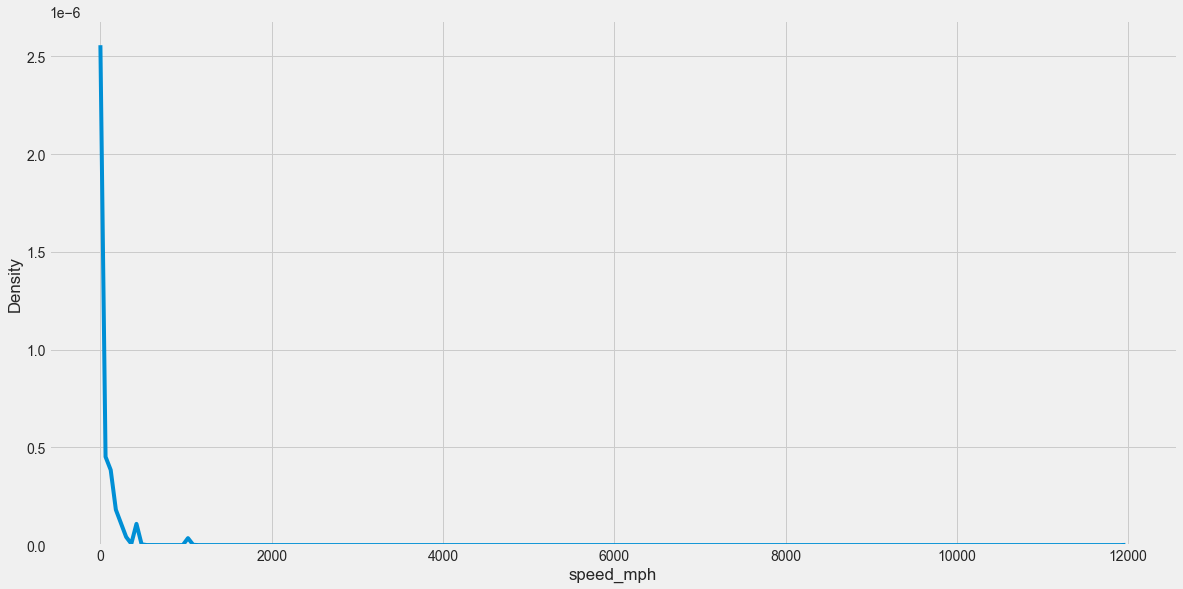

In [29]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.speed_mph)
plt.show()

In [30]:
CB_Data.sort_values(by=['speed_mph'], ascending = False).head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
25486948,Member,Classic Bike,2022-03-19 13:06:11,Murray St & West St,40.71,-74.01,Manhattan,Tribeca,2022-03-19 13:06:14,Lenox Ave & W 111 St,40.80,-73.95,Manhattan,Harlem,2022,3,11,5,13,0.05,9.97,11966.16
1161527,Member,Classic Bike,2021-05-20 09:12:19,21 Ave & Shore Blvd,40.78,-73.92,Queens,Ditmars Steinway,2021-05-20 09:12:20,31 Ave & 30 St,40.76,-73.92,Queens,Astoria,2021,5,20,3,9,0.02,1.82,6556.02
1481681,Casual,Classic Bike,2021-05-09 14:22:07,Mercer St & Spring St,40.72,-74.00,Manhattan,SoHo,2021-05-09 14:22:08,E 11 St & 1 Ave,40.73,-73.98,Manhattan,East Village,2021,5,18,6,14,0.02,1.46,5250.95
692576,Member,Classic Bike,2021-05-04 16:21:38,Broadway & W 38 St,40.75,-73.99,Manhattan,Midtown,2021-05-04 16:21:43,West Thames St,40.71,-74.02,Manhattan,Battery Park City,2021,5,18,1,16,0.08,5.13,3696.81
25734125,Member,Classic Bike,2022-03-03 18:04:47,W 55 St & 6 Ave,40.76,-73.98,Manhattan,Midtown,2022-03-03 18:04:54,Clark St & Henry St,40.70,-73.99,Brooklyn,Brooklyn Heights,2022,3,9,3,18,0.12,5.56,2860.10


It appears that for these rides, there seems to be some irregularity with respect to their being assigned to their tracking devices, particularly for the distances being traveled. Therfore, assume that all rides are at least 1 min to begin trimming down this set of junk data.

In [31]:
CB_Data = CB_Data.loc[CB_Data.duration_min >= 1]

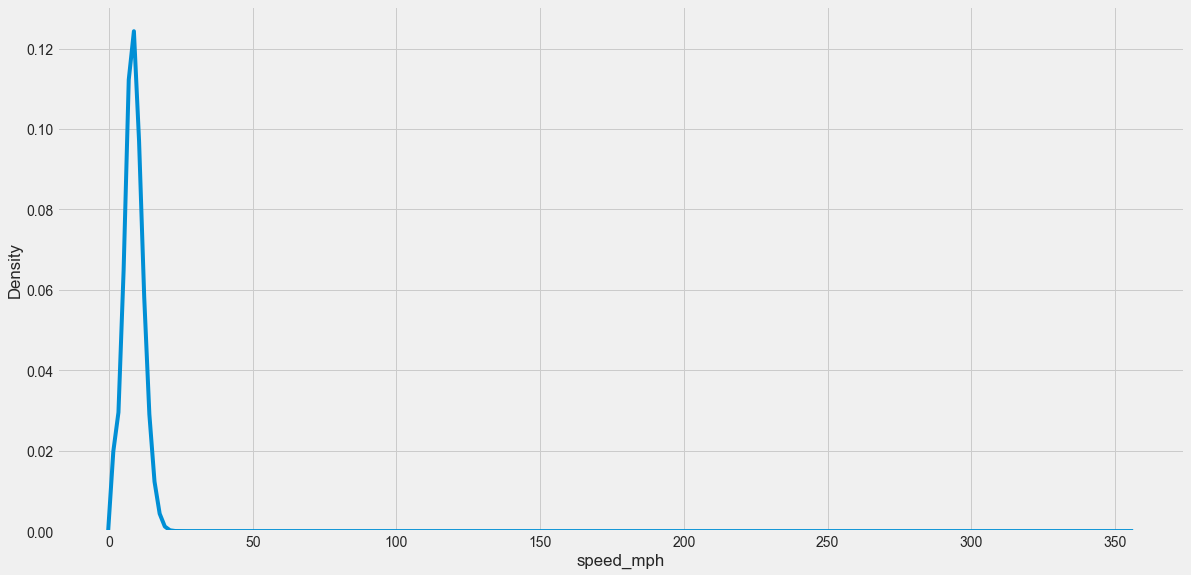

In [32]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.speed_mph)
plt.show()

The data appears more digestible, but such unnaturally high speed bike rides still have not been eliminated. Time for a second look.

In [33]:
CB_Data.sort_values(by=['speed_mph'], ascending = False).head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
24818936,Member,Classic Bike,2022-03-09 18:11:53,Van Brunt St & Van Dyke St,40.68,-74.01,Brooklyn,Red Hook,2022-03-09 18:12:55,Union Ave & Wallabout St,40.70,-73.95,Brooklyn,Williamsburg,2022,3,10,2,18,1.03,6.13,356.03
24806384,Member,Classic Bike,2022-03-19 17:32:11,Lexington Ave & E 26 St,40.74,-73.98,Manhattan,Kips Bay,2022-03-19 17:33:20,Lenox Ave & W 117 St,40.80,-73.95,Manhattan,Harlem,2022,3,11,5,17,1.15,6.58,343.12
25722027,Member,Classic Bike,2022-03-04 07:37:55,West End Ave & W 107 St,40.80,-73.97,Manhattan,Upper West Side,2022-03-04 07:39:32,Clark St & Henry St,40.70,-73.99,Brooklyn,Brooklyn Heights,2022,3,9,4,7,1.62,8.95,332.35
1257548,Casual,Classic Bike,2021-05-16 14:00:26,W 20 St & 10 Ave,40.75,-74.01,Manhattan,Chelsea,2021-05-16 14:01:33,Riverside Dr & W 91 St,40.79,-73.98,Manhattan,Upper West Side,2021,5,19,6,14,1.12,5.22,280.23
28687336,Member,Classic Bike,2022-04-21 08:27:14,Willoughby Ave & Myrtle Ave,40.70,-73.93,Brooklyn,Bushwick,2022-04-21 08:28:53,Carmine St & 6 Ave,40.73,-74.00,Manhattan,West Village,2022,4,16,3,8,1.65,7.18,260.91


Raise the threshold to two minutes, just for a careful increment to prevent too much data loss.

In [34]:
CB_Data = CB_Data.loc[CB_Data.duration_min >= 2]

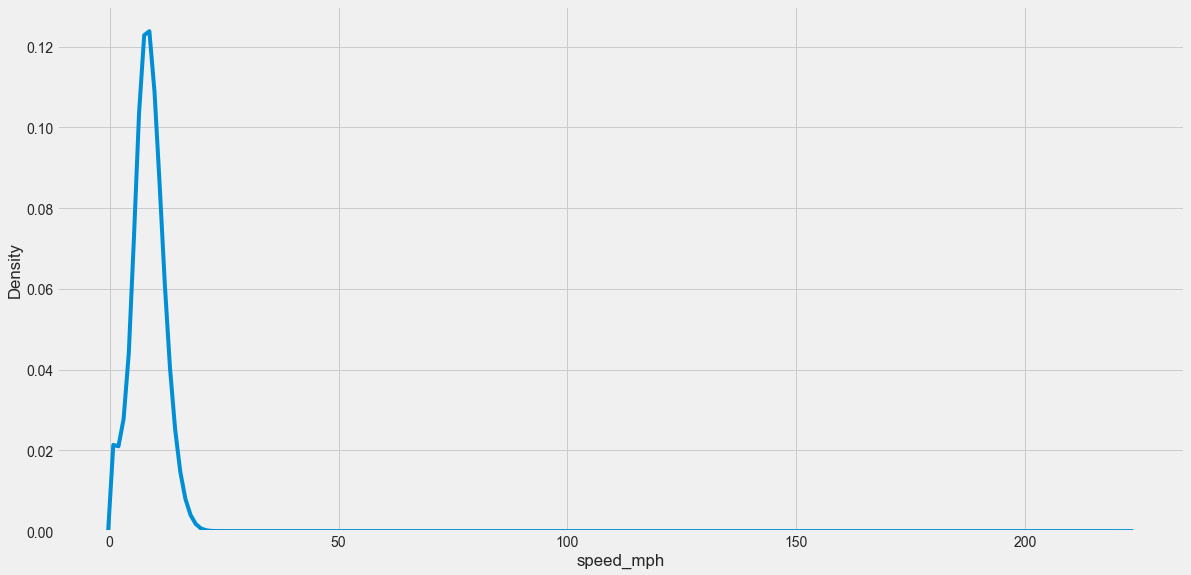

In [35]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.speed_mph)
plt.show()

In [36]:
CB_Data.sort_values(by=['speed_mph'], ascending = False).head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
879927,Member,Classic Bike,2021-05-03 15:05:56,W 43 St & 10 Ave,40.76,-73.99,Manhattan,Hell's Kitchen,2021-05-03 15:08:17,W 155 St & Frederick Douglass Blvd,40.83,-73.94,Manhattan,Washington Heights,2021,5,18,0,15,2.35,8.75,223.31
25734525,Member,Classic Bike,2022-03-03 18:40:33,Lenox Ave & W 111 St,40.80,-73.95,Manhattan,Harlem,2022-03-03 18:43:26,Clark St & Henry St,40.70,-73.99,Brooklyn,Brooklyn Heights,2022,3,9,3,18,2.88,9.82,204.36
25476207,Member,Classic Bike,2022-03-25 22:22:27,Greenwich St & W Houston St,40.73,-74.01,Manhattan,SoHo,2022-03-25 22:25:16,Lenox Ave & W 111 St,40.80,-73.95,Manhattan,Harlem,2022,3,12,4,22,2.82,8.71,185.54
25494375,Member,Classic Bike,2022-03-22 12:01:07,E 11 St & 3 Ave,40.73,-73.99,Manhattan,East Village,2022-03-22 12:03:33,Lenox Ave & W 111 St,40.80,-73.95,Manhattan,Harlem,2022,3,12,1,12,2.43,7.16,176.44
25489225,Member,Classic Bike,2022-03-25 22:55:18,6 Ave & Broome St,40.72,-74.00,Manhattan,SoHo,2022-03-25 22:58:18,Lenox Ave & W 111 St,40.80,-73.95,Manhattan,Harlem,2022,3,12,4,22,3.00,8.76,175.13


Step it up to five minutes.

In [37]:
CB_Data = CB_Data.loc[CB_Data.duration_min >= 5]

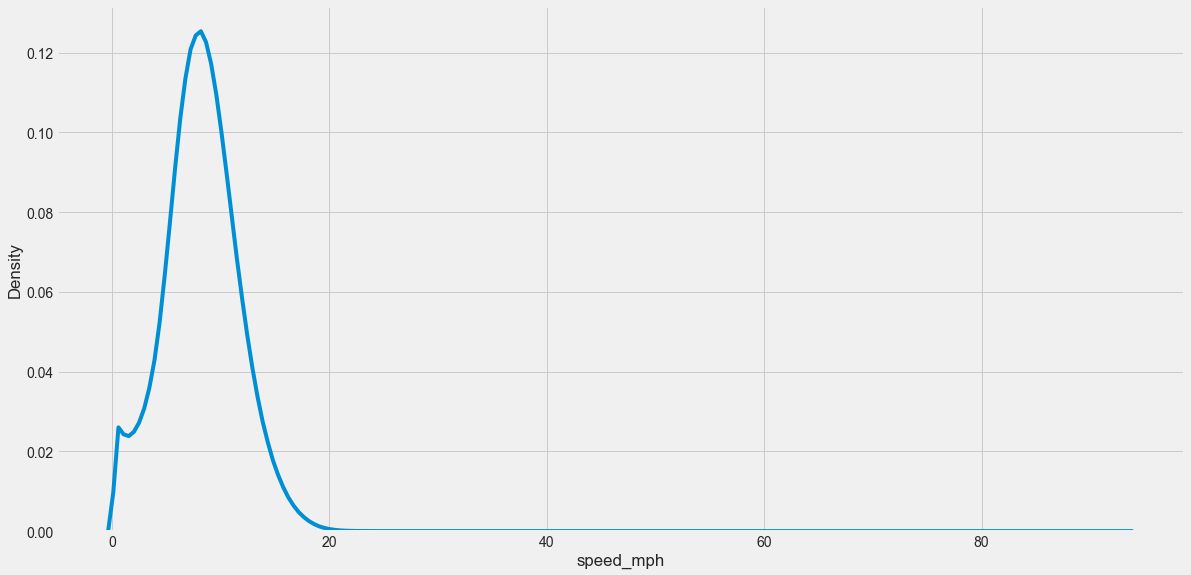

In [38]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.speed_mph)
plt.show()

Since it is a rule of thumb that eBikes at the most cannot travel faster than 20 mph, eliminate rides that exceed that value.

In [39]:
CB_Data = CB_Data.loc[CB_Data.speed_mph <= 20]

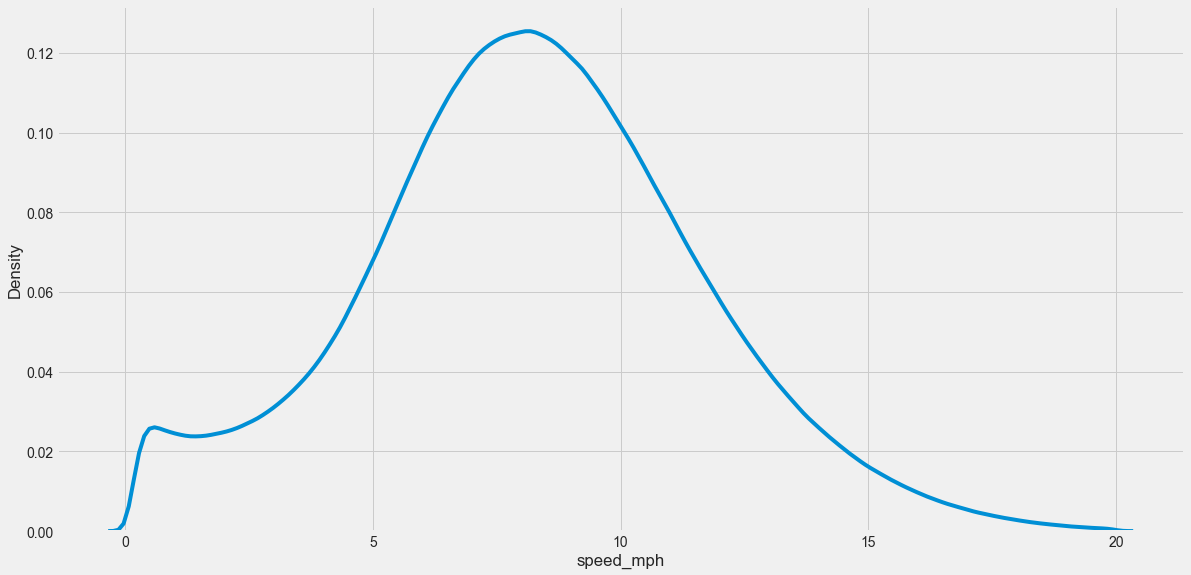

In [40]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.speed_mph)
plt.show()

Finally, it is not possible that rides go at 0 mph, therefore assume that they are at least 1 mph to assume a sloppy ride from one station to another due to a rider changing one's mind about riding or choice of bike.

In [41]:
CB_Data = CB_Data.loc[CB_Data.speed_mph >= 1]

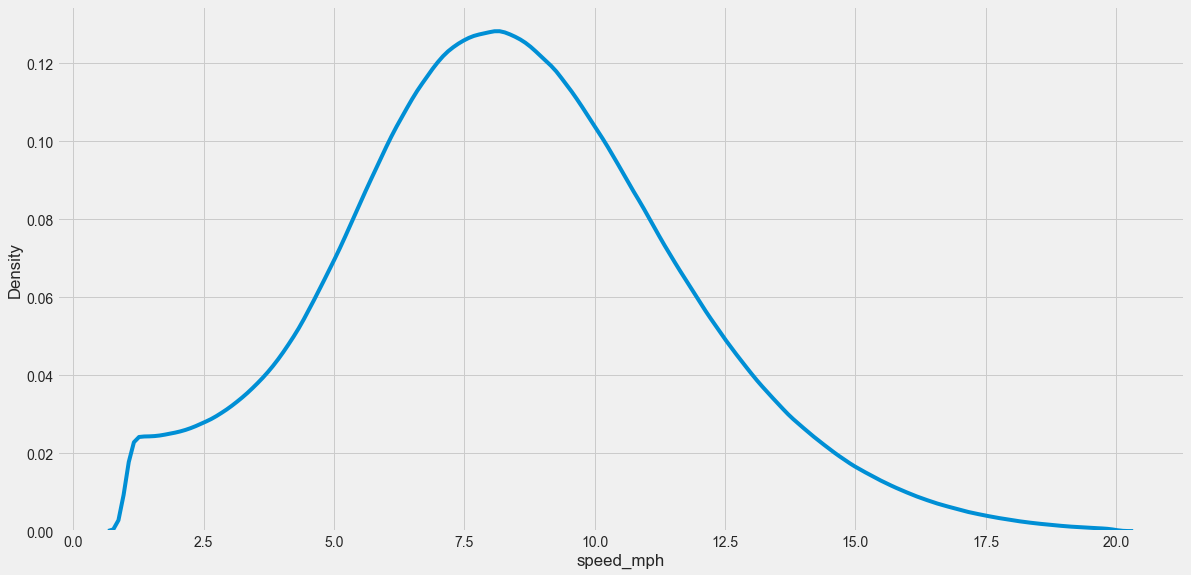

In [42]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.speed_mph)
plt.show()

In [43]:
CB_Data.sort_values(by=['speed_mph'], ascending = True).head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
1301572,Member,Classic Bike,2021-05-14 16:56:28,Harrison St & Hudson St,40.72,-74.01,Manhattan,Tribeca,2021-05-14 17:07:05,Hudson St & Reade St,40.72,-74.01,Manhattan,Tribeca,2021,5,19,4,16,10.62,0.18,1.00
3863847,Member,Classic Bike,2021-06-29 12:57:19,2 Ave & E 96 St,40.78,-73.95,Manhattan,Upper East Side,2021-06-29 13:15:01,E 95 St & 3 Ave,40.78,-73.95,Manhattan,Upper East Side,2021,6,26,1,12,17.70,0.30,1.00
13279634,Member,Classic Bike,2021-09-30 18:38:31,21 Ave & Crescent St,40.78,-73.91,Queens,Ditmars Steinway,2021-09-30 19:12:18,21 Ave & Shore Blvd,40.78,-73.92,Queens,Ditmars Steinway,2021,9,39,3,18,33.78,0.56,1.00
21004986,Member,Classic Bike,2021-12-21 13:31:40,Amsterdam Ave & W 125 St,40.81,-73.96,Manhattan,Morningside Heights,2021-12-21 14:08:27,12 Ave & W 125 St,40.82,-73.96,Manhattan,Harlem,2021,12,51,1,13,36.78,0.61,1.00
13089231,Member,Classic Bike,2021-09-14 17:42:27,Union Ave & N 12 St,40.72,-73.95,Brooklyn,Greenpoint,2021-09-14 18:25:20,Kent Ave & N 7 St,40.72,-73.96,Brooklyn,Williamsburg,2021,9,37,1,17,42.88,0.71,1.00


That one kink in the curve probably indicates riders riding around without a specific purpose in mind and is better to eliminate entirely in order to smooth out the density curve. Since a typical human walking speed is estimated to be 3 - 4 mph, it makes no sense to ride a bike to not exceed that. Therefore, set 5 mph as a the minimum speed for bike rides, since below that assumes too much unusual conditions in the ride itself.

In [55]:
CB_Data = CB_Data.loc[CB_Data.speed_mph >= 5]

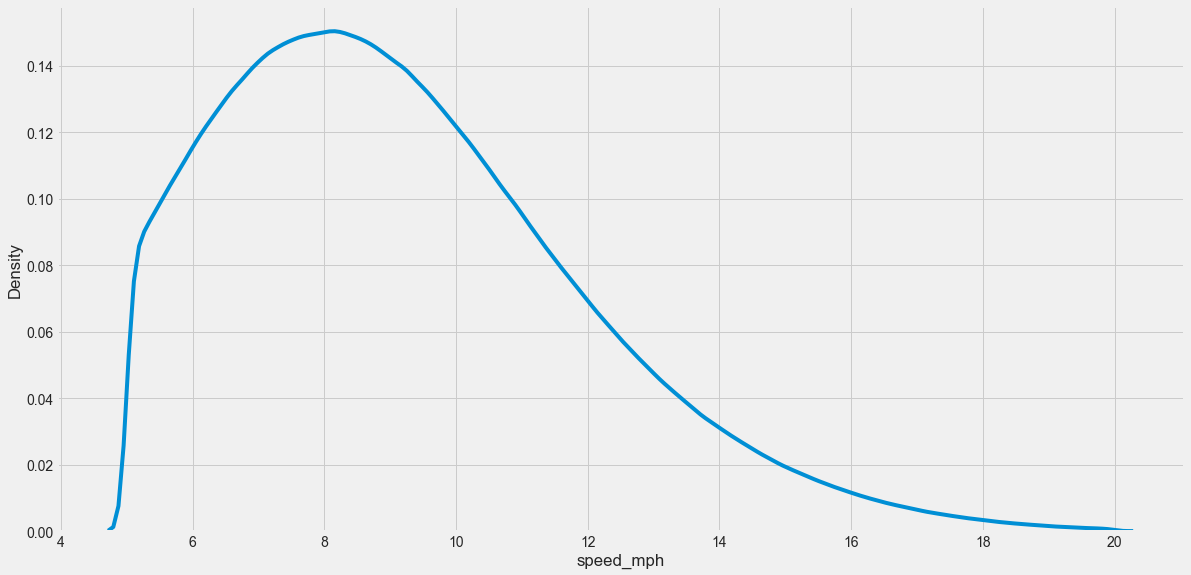

In [56]:
plt.figure(figsize=(18,9))
sns.kdeplot(CB_Data.speed_mph)
plt.show()

In [57]:
CB_Data.sort_values(by=['speed_mph'], ascending = True).head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
14595383,Casual,Classic Bike,2021-09-04 22:21:16,Reade St & Broadway,40.71,-74.01,Manhattan,Civic Center,2021-09-04 22:45:47,E 2 St & Avenue B,40.72,-73.98,Manhattan,East Village,2021,9,35,5,22,24.52,2.04,5.00
434799,Member,Classic Bike,2021-05-16 18:54:23,1 Ave & E 78 St,40.77,-73.95,Manhattan,Upper East Side,2021-05-16 19:14:24,E 58 St & 3 Ave,40.76,-73.97,Manhattan,Midtown,2021,5,19,6,18,20.02,1.67,5.00
9910684,Casual,Classic Bike,2021-08-28 15:34:25,William St & Pine St,40.71,-74.01,Manhattan,Financial District,2021-08-28 15:55:48,Mercer St & Spring St,40.72,-74.00,Manhattan,SoHo,2021,8,34,5,15,21.38,1.78,5.00
16954339,Member,Classic Bike,2021-10-10 16:40:19,34 St & 4 Ave,40.66,-74.00,Brooklyn,Sunset Park,2021-10-10 16:46:56,41 St & 4 Ave,40.65,-74.01,Brooklyn,Sunset Park,2021,10,40,6,16,6.62,0.55,5.00
9746510,Member,Classic Bike,2021-08-13 21:41:39,Clinton St\t& Cherry St,40.71,-73.99,Manhattan,Lower East Side,2021-08-13 21:51:34,Allen St & Rivington St,40.72,-73.99,Manhattan,Lower East Side,2021,8,32,4,21,9.92,0.83,5.00


<function matplotlib.pyplot.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)>

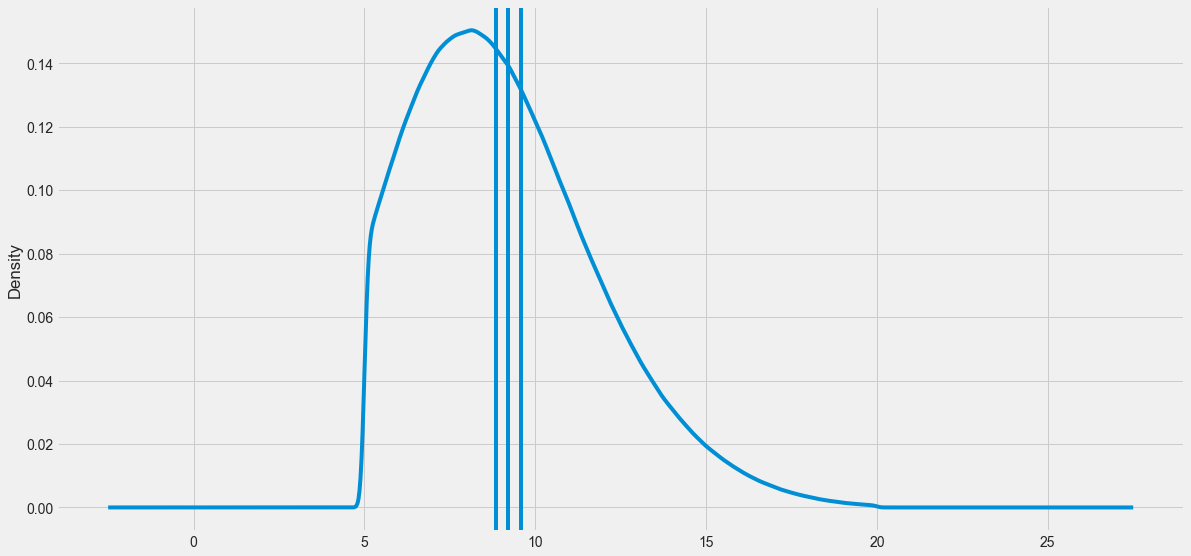

In [62]:
# Visualizing mean, median, and mode for ride speed.
plt.figure(figsize = (18,9))
CB_Data.speed_mph.plot(kind='density')
plt.axvline(CB_Data.speed_mph.mean(), label='Mean')
plt.axvline(CB_Data.speed_mph.median(), label='Median')
plt.axvline(statistics.mode(CB_Data.speed_mph), label='Mode')
plt.boxplot

In [59]:
print(f'The average ride speed is: {CB_Data.speed_mph.mean()} mph.')
print(f'The median ride speed is: {CB_Data.speed_mph.mean()} mph.')
print(f'The typical ride speed is: {statistics.mode(CB_Data.speed_mph)} mph.')

The average ride speed is: 9.2167567178771 mph.
The median ride speed is: 9.2167567178771 mph.
The typical ride speed is: 9.582826362943905 mph.


<a href=#toc>Back to the top</a>

<a id=04-final></a>
## Final Results

In [61]:
CB_Data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
member_casual,18658426,2,Member,13885173,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rideable_type,18658426,2,Classic Bike,13019655,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,18658426,12040084,2021-06-25 19:08:09,27,2021-05-01 00:00:01,2022-04-30 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_name,18658426,1587,W 21 St & 6 Ave,84118,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_lat,18658426.00,NaN,NaN,NaN,NaT,NaT,40.74,0.04,40.63,40.72,40.74,40.76,40.88
start_lng,18658426.00,NaN,NaN,NaN,NaT,NaT,-73.98,0.02,-74.04,-73.99,-73.98,-73.96,-73.88
start_boro,18658426,5,Manhattan,13542212,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_hood,18658426,89,Chelsea,1429536,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ended_at,18658426,12033810,2021-05-05 23:31:09,36,2021-05-01 00:06:03,2022-05-01 00:48:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_name,18658426,1654,W 21 St & 6 Ave,88605,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This gradual reduction of outlier rides that are probably not legitimate ones seems to have calmed the extreme noise in the data. Finally, examine the overall distribution of data to check for any more iregularities.

<a href=#toc>Back to the top</a>

<a id=04-a-durations></a>
### Ride Durations

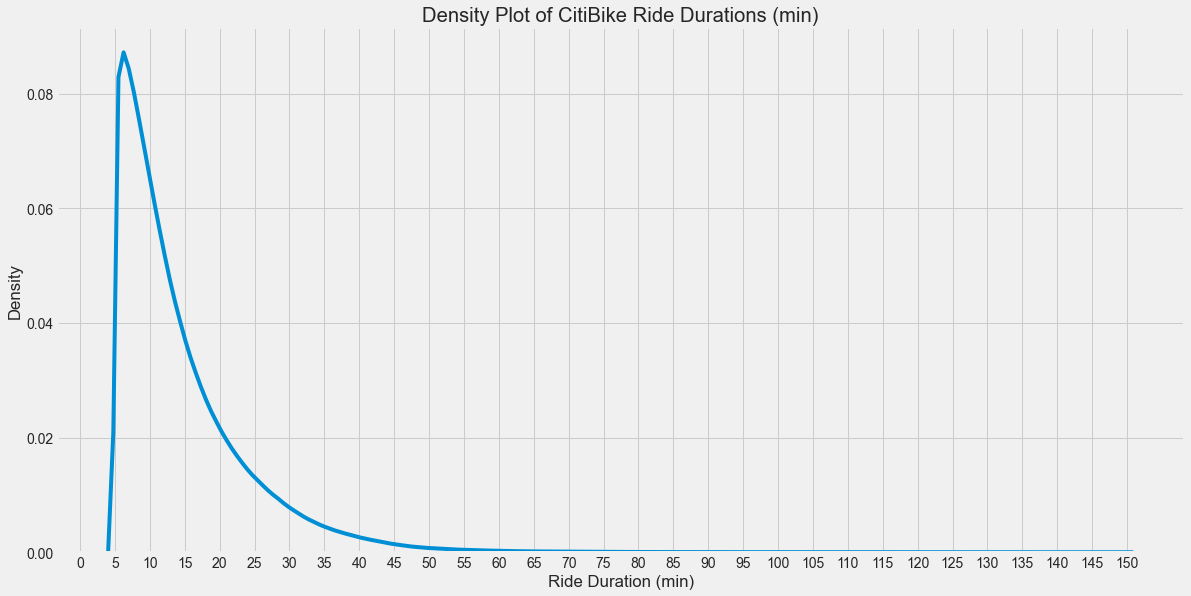

In [8]:
# Distribution of ride durations (min)
plt.figure(figsize=(18,9))
g = sns.kdeplot(CB_Data.duration_min)
plt.title('Density Plot of CitiBike Ride Durations (min)')
g.set_xticks(list(range(0,155,5)))
plt.xlabel('Ride Duration (min)')
plt.show()

<a href=#toc>Back to the top</a>

<a id=04-b-distances></a>
### Ride Distances

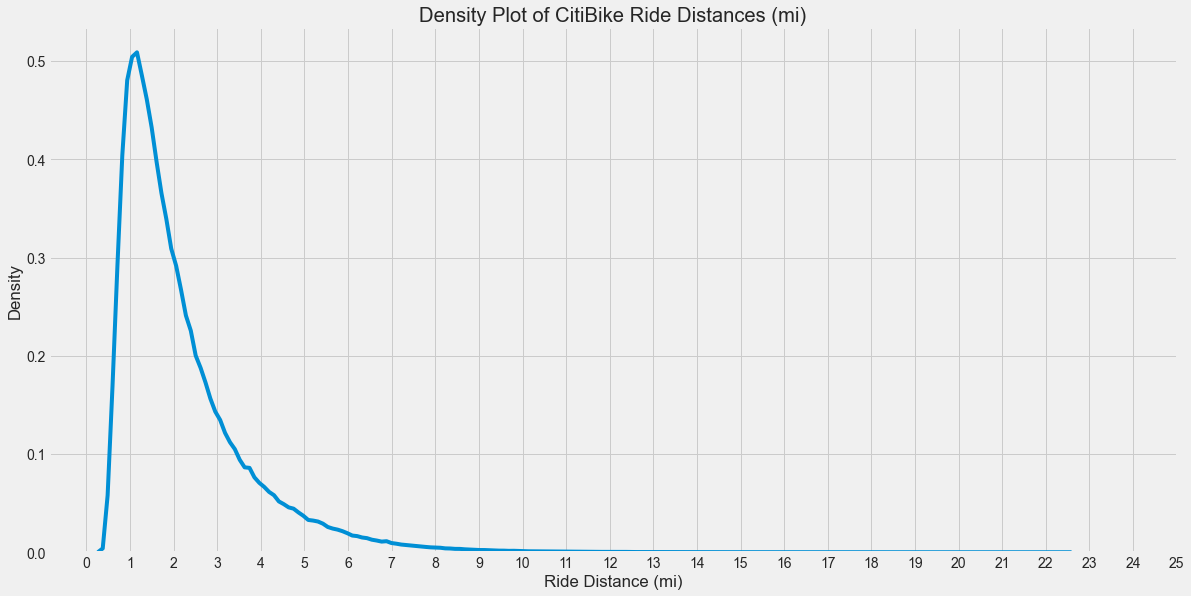

In [9]:
# Distribution of ride distances (mi)
plt.figure(figsize=(18,9))
g = sns.kdeplot(CB_Data.distance_mi)
plt.title('Density Plot of CitiBike Ride Distances (mi)')
g.set_xticks(list(range(0,26,1)))
plt.xlabel('Ride Distance (mi)')
plt.show()

<a href=#toc>Back to the top</a>

<a id=04-c-speeds></a>
### Ride Speeds

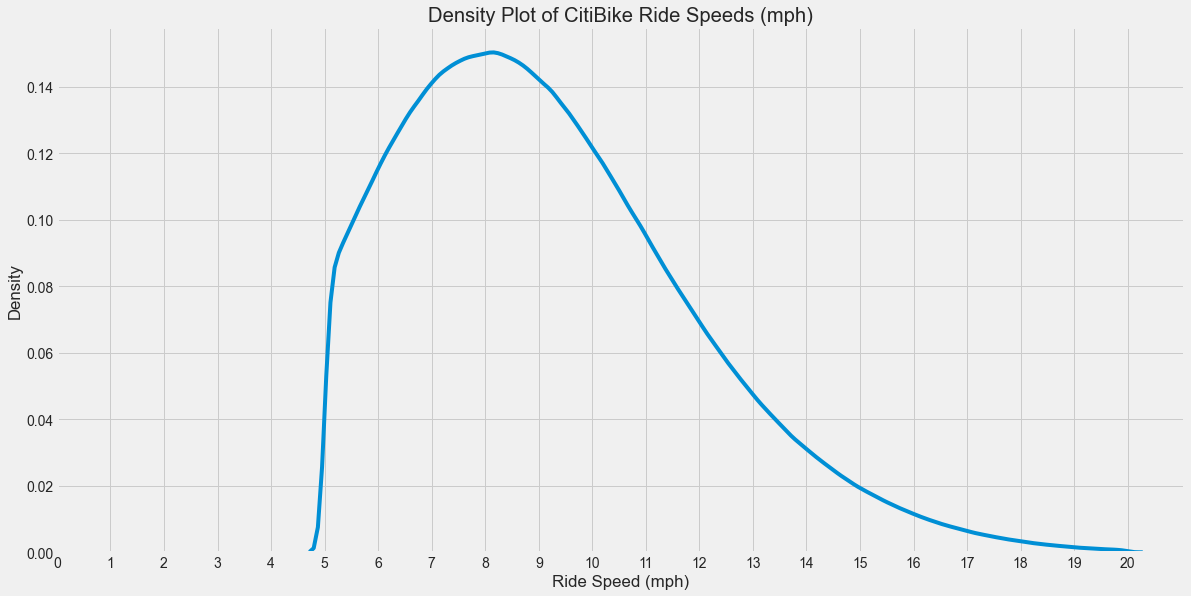

In [10]:
# Distribution of ride speeds (mph)
plt.figure(figsize=(18,9))
g = sns.kdeplot(CB_Data.speed_mph)
plt.title('Density Plot of CitiBike Ride Speeds (mph)')
g.set_xticks(list(range(0,21,1)))
plt.xlabel('Ride Speed (mph)')
plt.show()

<a href=#toc>Back to the top</a>

<a id=05-records></a>
## Records

<a id=05-a-duration></a>
### Longest Ride (Duration)

In [67]:
CB_Data.loc[CB_Data.duration_min == CB_Data.duration_min.max()]

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
11894480,Casual,Classic Bike,2021-08-26 12:58:59,King St & Varick St,40.73,-74.01,Manhattan,SoHo,2021-08-26 15:28:53,Dyckman St & Staff St,40.87,-73.93,Manhattan,Inwood,2021,8,34,3,12,149.90,14.82,5.93


<a id=05-b-distance></a>
### Longest Ride (Distance)

In [68]:
CB_Data.loc[CB_Data.distance_mi == CB_Data.distance_mi.max()]

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
21231254,Member,Electric Bike,2021-12-06 16:44:44,W 212 St & 10 Ave,40.87,-73.92,Manhattan,Inwood,2021-12-06 18:25:39,57 St & 4 Ave,40.64,-74.02,Brooklyn,Sunset Park,2021,12,49,0,16,100.92,22.43,13.34


<a id=05-c-speed></a>
### Fastest Ride

In [69]:
CB_Data.loc[CB_Data.speed_mph == CB_Data.speed_mph.max()]

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
223502,Member,Classic Bike,2021-05-21 00:20:19,E 63 St & 3 Ave,40.76,-73.96,Manhattan,Upper East Side,2021-05-21 00:27:55,Queens Plaza North & Crescent St,40.75,-73.94,Queens,Long Island City,2021,5,20,4,0,7.60,2.53,20.00


<a href=#toc>Back to the top</a>

<a id=06-save></a>
## Save Cleaned File

This data at this point seems usable enough to warrant saving to a **.parquet** file to resume the rest of the machine learning time series analysis and modeling.

In [72]:
CB_Data.shape

(18658426, 22)

In [70]:
CB_Data_arrow = pa.Table.from_pandas(CB_Data)
pq.write_table(CB_Data_arrow, 'data/202105-202204-citibike-tripdata.parquet')

<a href=#toc>Back to the top</a>